In [2]:
import cv2
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ROOT_DATA_PATH = './data/set-lipstick-original'
IMAGE_DATA_PATH = ROOT_DATA_PATH + '/720p'
MASK_DATA_PATH = ROOT_DATA_PATH + '/mask'
LIST_DATA_PATH = ROOT_DATA_PATH + '/list.csv'
IMAGE_SIZE = 256

In [6]:
from pathlib import Path
from pandas import read_csv

list_of_a_masks = sorted([i for i in Path(MASK_DATA_PATH).iterdir()])
df_lips_images = read_csv(LIST_DATA_PATH)


df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)

del Path, list_of_a_masks, read_csv

In [7]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    image = cv2.imread(IMAGE_DATA_PATH + '/' + image_filename)
    mask = cv2.imread(MASK_DATA_PATH + '/' + mask_filename)
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask

In [51]:
class LipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, -1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMAGE_SIZE)
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)

        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return img.float(), masks

In [52]:
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn

model = Unet(encoder_name='resnet18', classes=1, activation='sigmoid')
model.to(device)

preprocess_input = get_preprocessing_fn(encoder_name='resnet18', pretrained='imagenet')

del get_preprocessing_fn, Unet

In [53]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False)

del DataLoader, X_train, X_valid, train_data, valid_data, train_test_split

In [54]:
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU
from torch.optim import Adam

criterion = DiceLoss()
metrics = [IoU()]
optimizer = Adam(model.parameters(), lr=0.001)

del DiceLoss, IoU, Adam

In [55]:
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch

train_epoch = TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

del TrainEpoch, ValidEpoch

In [56]:
max_score = 0

for i in range(1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_1.pth')
        print('Model saved!')

Epoch: 1
train:   3%|▉                               | 71/2498 [17:08<9:46:01, 14.49s/it, dice_loss - 0.7747, iou_score - 0.3031]


KeyboardInterrupt: 

In [57]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


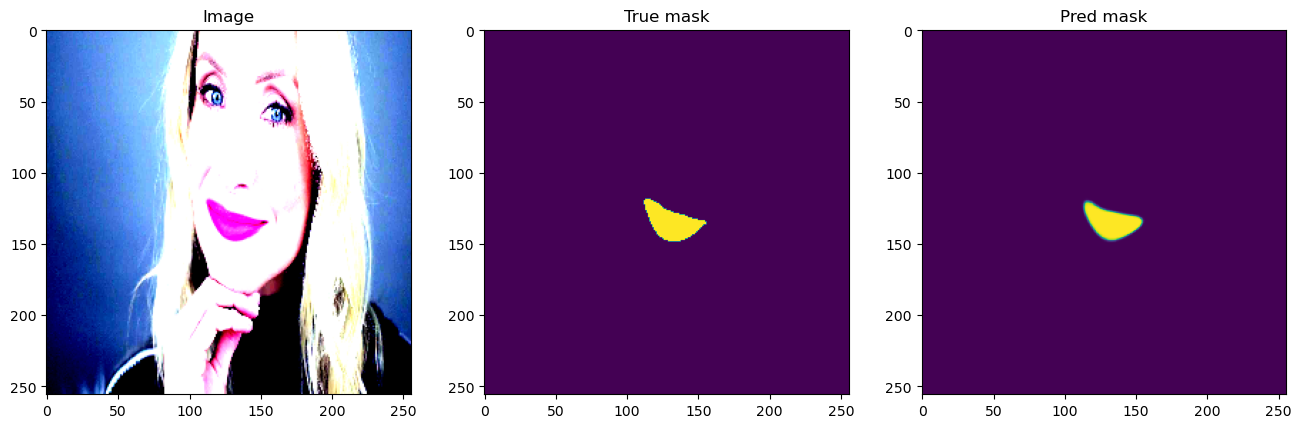

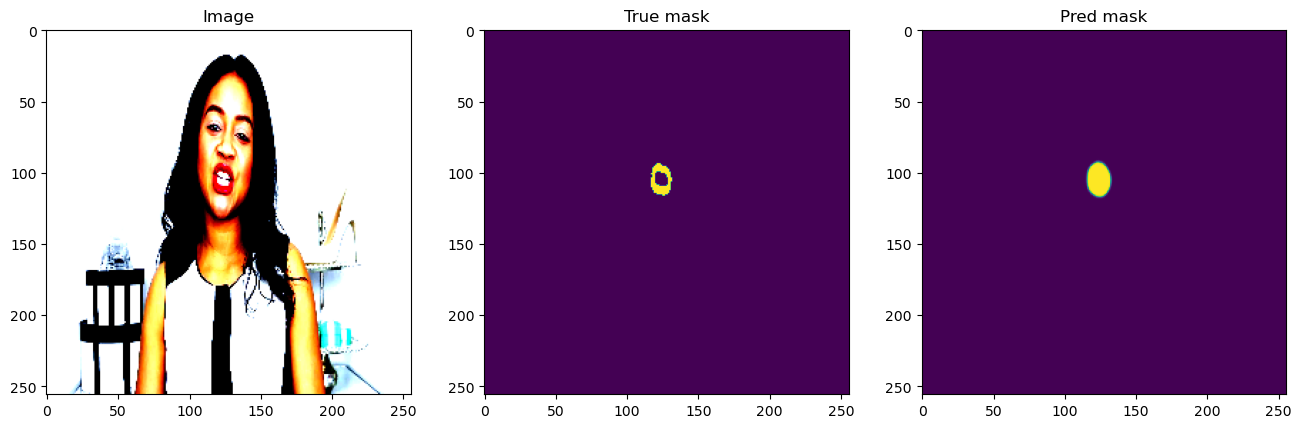

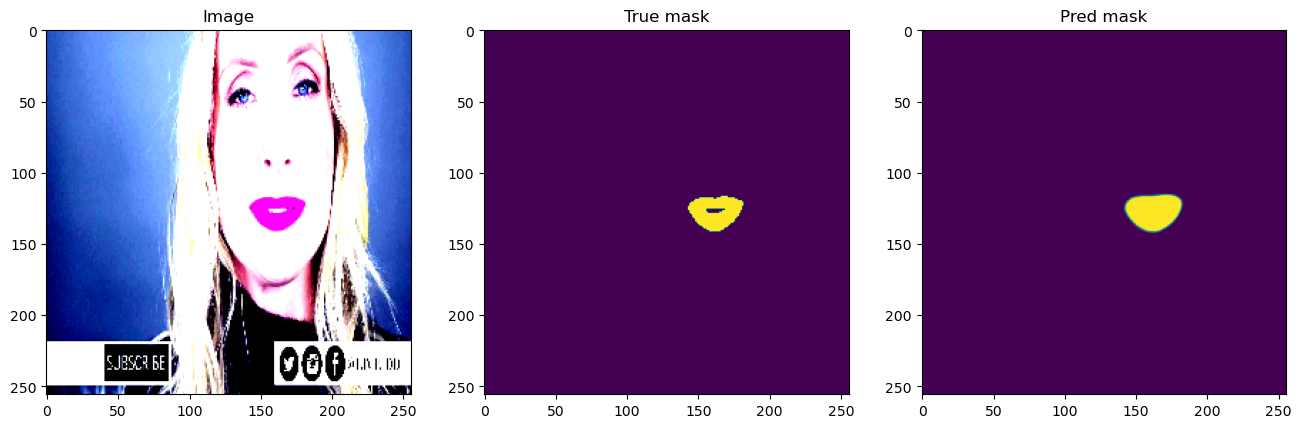

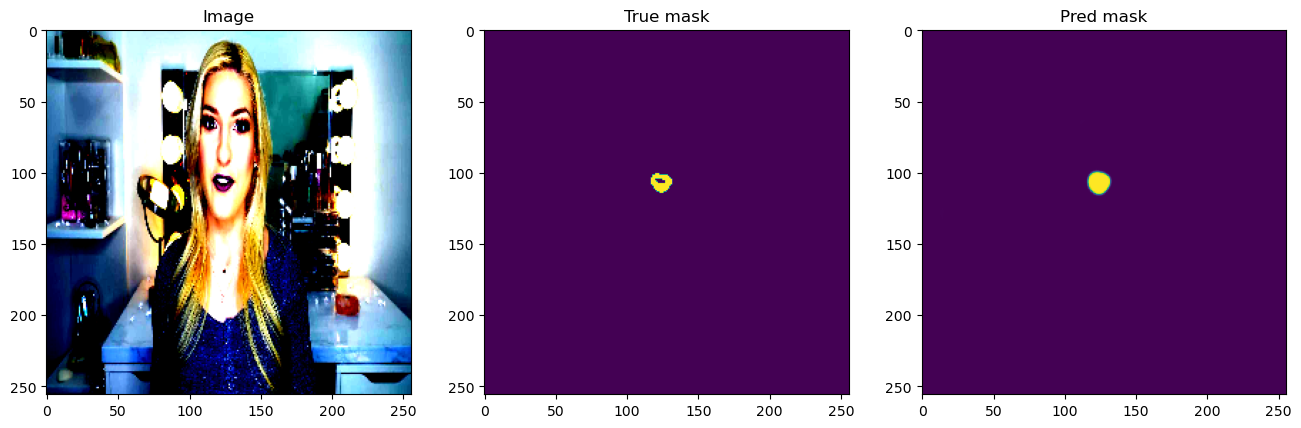

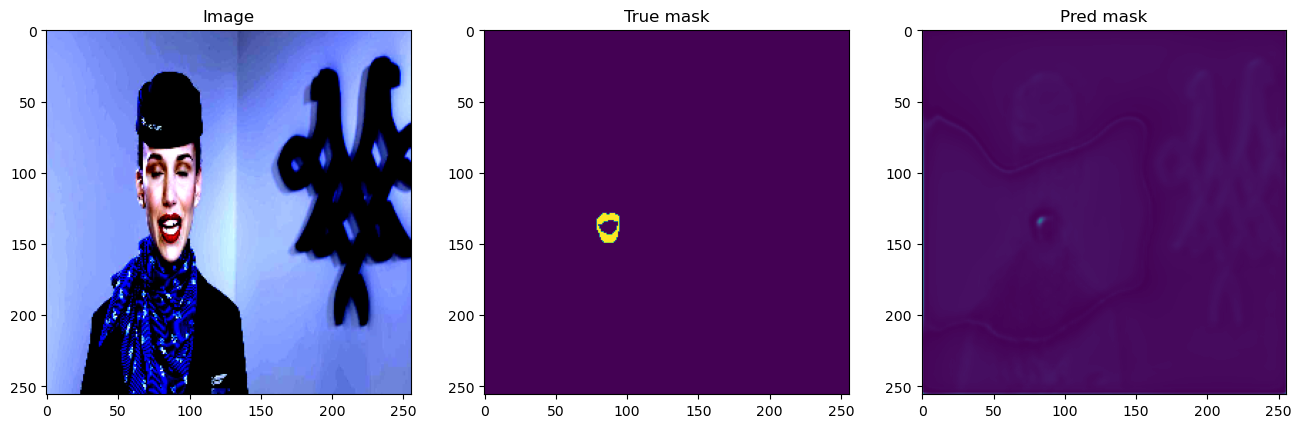

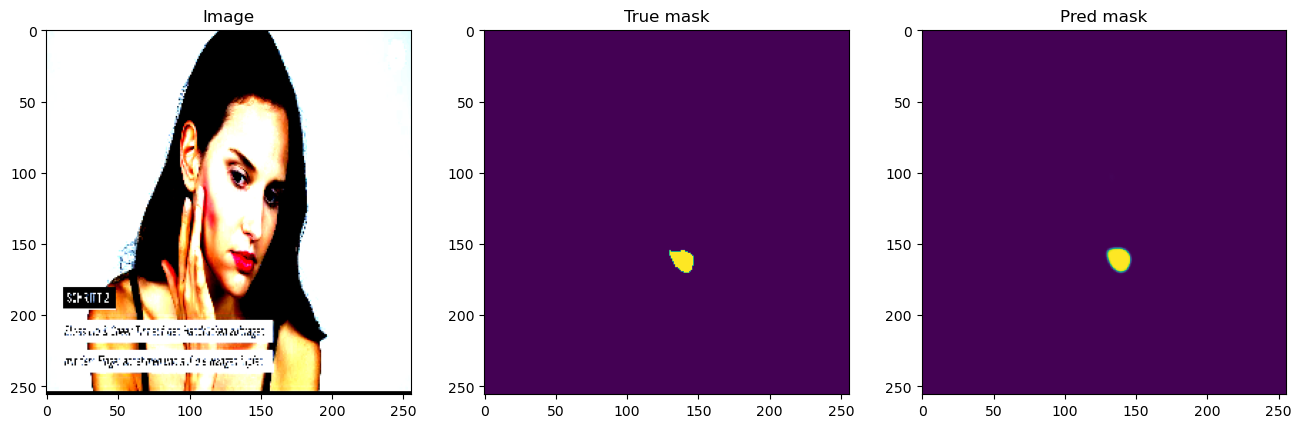

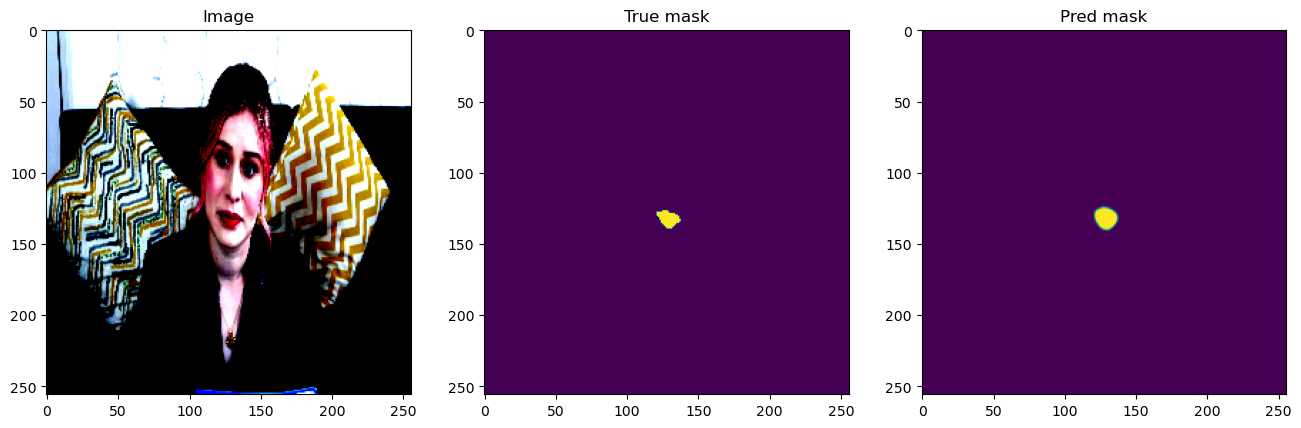

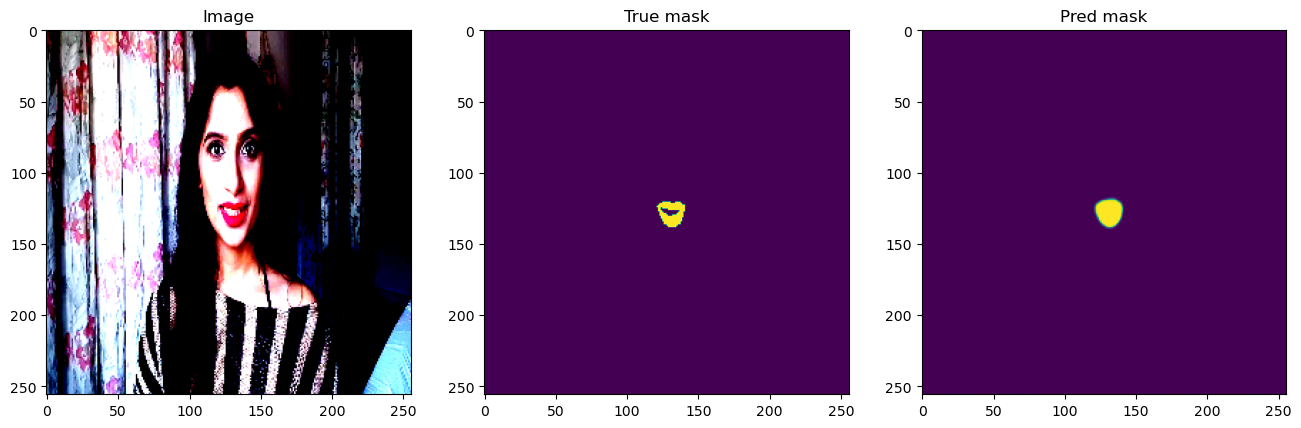

In [58]:
import matplotlib.pyplot as plt

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')
    
del plt